# Machine Learning mini-project

## Understanding Classification and Regression (12 points)

### Classification

Describe a classification problem in chemical, biochemical, or environmental engineering (that is not related to drug discovery, since we've explored that in class). Specify the label of interest, and list at least 2 features that may be relevant for classification. If relevant, provide the units of the variables.

**<font color=blue>0 / 6 points</font>**

Describe the problem:

Label:

Features:

### Regression

Describe a regression problem in chemical, biochemical, or environmental engineering (that is not related to thermodynamic properties, since we've covered that in class). Specify the label of interest, and list at least 2 features that may be relevant for regression. Also provide the units of the variables, if relevant.

**<font color=blue>0 / 6 points</font>**

Describe the problem:

Label:

Features:

**Use the cell below to import any libraries you need for this notebook**

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


## Part 1: The white wine dataset (45 points)

### Reading and sorting the dataset (5 points)

**<font color=blue>0 / 5 points</font>** Read in the **white** wine quality dataset (find it in the datasets folder on Blackboard), sort it by residual sugar and then by alcohol content, and re-index the rows, so the sorted dataframe goes from 0 to max

In [29]:
#read the white wine quality csv, note the provided csv from class had an error in it. If it hasnt been fixed yet
#then open up the csv and find and replace all of the ; with , and it should work.
wine = pd.read_csv('winequality-white.csv')

#first use sort values to arrange by sugar and then alcohol and afterwards re index the frame to leave it in this order
wine = df.sort_values(by=['residual sugar','alcohol']).reset_index(drop=True) #drop = True gets rid of the old index
wine.tail(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4888,6.9,0.240,0.36,20.80,0.031,40.0,139.0,0.99750,3.20,0.33,11.0,6
4889,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
4890,6.8,0.280,0.40,22.00,0.048,48.0,167.0,1.00100,2.93,0.50,8.7,5
4891,5.9,0.220,0.45,22.60,0.120,55.0,122.0,0.99636,3.10,0.35,12.8,5
4892,6.9,0.270,0.49,23.50,0.057,59.0,235.0,1.00240,2.98,0.47,8.6,5
4893,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
4894,6.8,0.450,0.28,26.05,0.031,27.0,122.0,1.00295,3.06,0.42,10.6,6
4895,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
4896,7.9,0.330,0.28,31.60,0.053,35.0,176.0,1.01030,3.15,0.38,8.8,6
4897,7.8,0.965,0.60,65.80,0.074,8.0,160.0,1.03898,3.39,0.69,11.7,6


### Categorizing wines and analyzing their properties (10 points)

The LCBO sugar code categorizes wine as dry if it has less than 2% residual sugar, medium (or semi-dry or semi-sweet) if it has between 2 and 7% residual sugar, and sweet if it has >7% residual sugar. 

**<font color=blue>0 / 5 points</font>** Categorize each wine according to its sweetness, and add its category to the dataframe. If you can't figure out how to add the categories to the dataframe, partial credit will be given for creating separate dataframes for each category. Hint: I found [this page](https://datatofish.com/if-condition-in-pandas-dataframe/) to have helpful tips. Finally, what fraction of the wines are in each category?

In [45]:
#add category column, use list comprehension to define category based on residual sugar
wine['category'] = ['sweet' if x >7 else 'semi-sweet' if  x >=2 else 'dry' for x in wine['residual sugar']]
print('Wines in sweet category: ',wine.category.value_counts()[0],'/',wine.category.count(),'\n'
      'Wines in semi-sweet category: ',wine.category.value_counts()[1],'/',wine.category.count(),'\n'
      'Wines in dry category: ',wine.category.value_counts()[2],'/',wine.category.count(),'\n')

Wines in sweet category:  1955 / 4898 
Wines in semi-sweet category:  1522 / 4898 
Wines in dry category:  1421 / 4898 



**<font color=blue>0 / 5 points</font>** When wine is fermented, sugar is converted into alcohol. We might therefore expect that high-alcohol wines have less sugar. Do you observe this trend across the whole dataset? What about within each category (for example, among dry wines, do high-alcohol wines have less sugar)? No need to perform regression for this question; plotting the data and describing what you see is sufficient.

Text(0.5, 1.0, 'sugar and alcohol for dry wines')

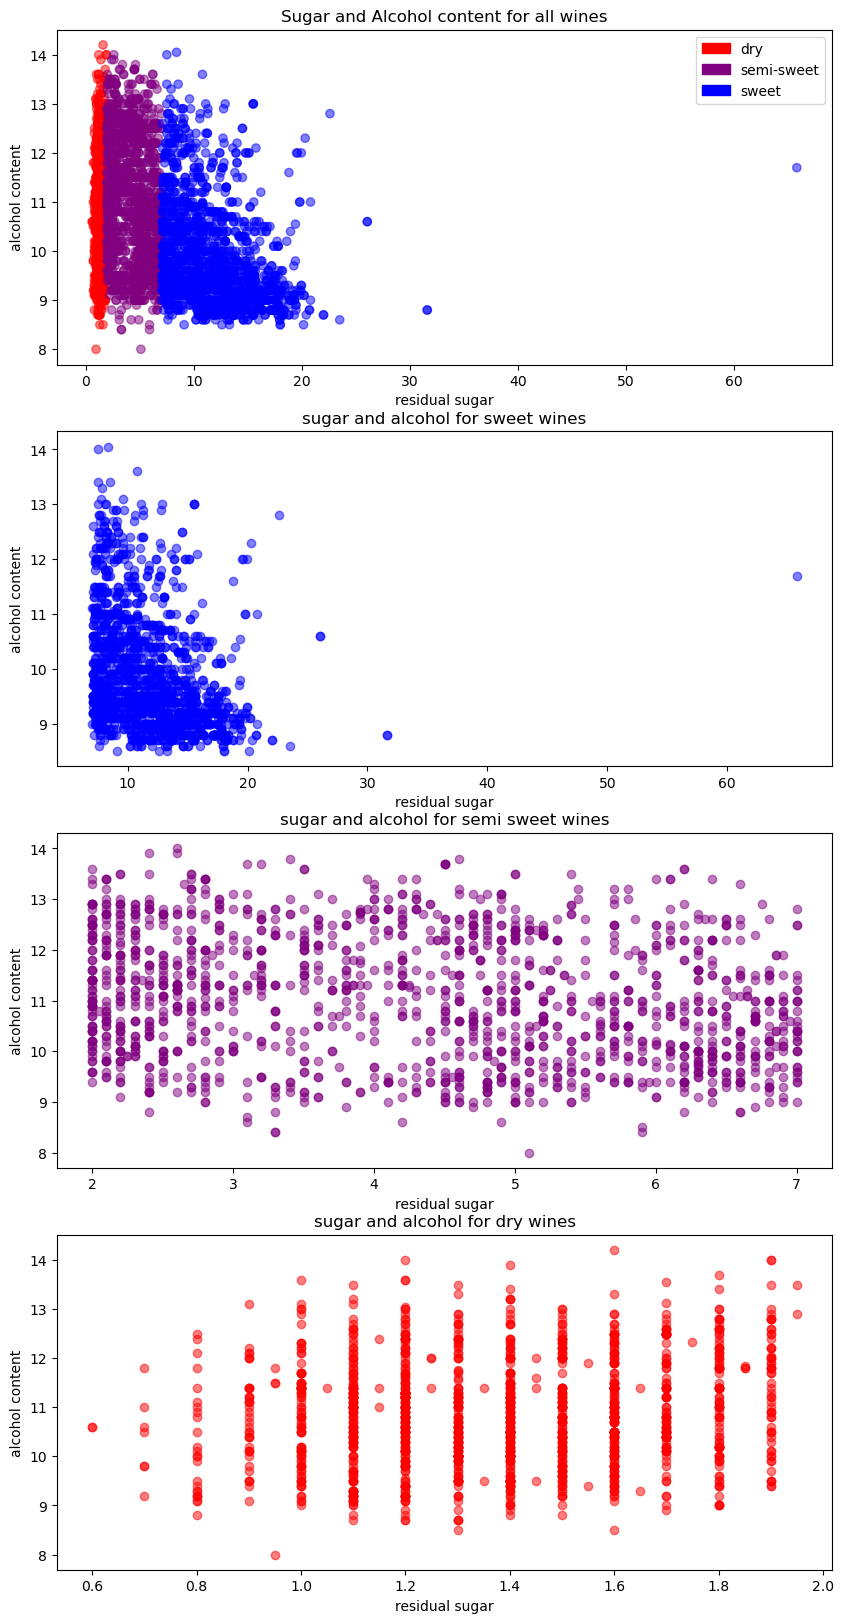

In [71]:
#dict to hold what colors to use based on sweetness
colors = {'sweet':'blue','semi-sweet':'purple','dry':'red'}

#create masks that will be used to select from sweetness categories
sweetMask = wine.category == 'sweet'
semiSweetMask = wine.category == 'semi-sweet'
dryMask = wine.category == 'dry'

#define all the plots I need
fig, ax = plt.subplots(4,figsize = (10,20))

ax[0].scatter(x = wine['residual sugar'],y=wine.alcohol,c=wine.category.map(colors),alpha = .5)
ax[0].set_xlabel('residual sugar')
ax[0].set_ylabel('alcohol content')
ax[0].set_title('Sugar and Alcohol content for all wines')
#utilizing patches to make sure legend is correct
red_patch = mpatches.Patch(color='red', label='dry')
purple_patch = mpatches.Patch(color='purple', label='semi-sweet')
blue_patch = mpatches.Patch(color='blue', label='sweet')
ax[0].legend(handles=[red_patch,purple_patch,blue_patch])

#plot the sweet wines only
ax[1].scatter(x = wine[sweetMask]['residual sugar'],y=wine[sweetMask].alcohol,c=colors['sweet'],alpha = .5)
ax[1].set_xlabel('residual sugar')
ax[1].set_ylabel('alcohol content')
ax[1].set_title('sugar and alcohol for sweet wines')

#plot the semi sweet wines
ax[2].scatter(x = wine[semiSweetMask]['residual sugar'],y=wine[semiSweetMask].alcohol,c=colors['semi-sweet'],alpha = .5)
ax[2].set_xlabel('residual sugar')
ax[2].set_ylabel('alcohol content')
ax[2].set_title('sugar and alcohol for semi sweet wines')

#plot the dry wines
ax[3].scatter(x = wine[dryMask]['residual sugar'],y=wine[dryMask].alcohol,c=colors['dry'],alpha = .5)
ax[3].set_xlabel('residual sugar')
ax[3].set_ylabel('alcohol content')
ax[3].set_title('sugar and alcohol for dry wines')


There does not seem to be much correlation between residual sugar and alcohol content, many different alcohol contents exist at most sugar levels. There may be a small possitive correlation with sugar and alochol for dry wines and possibly a small negative correlation in the semi-sweet wines but they do not appear to be significant even if they exist

### Predicting wine quality (30 points)

**<font color=blue>0 / 5 points</font>** Normalize the data to give a mean of zero and a standard deviation of 1. Divide the dataset into training and test sets, with 30% of the data in the test set.

In [91]:
#get a list of columns for use in normalizing data
cols = wine.columns
#drop category as it does not have a std or mean to normalize
cols = cols.drop('category')
#normalize data
wineNorm = (wine[cols] - wine[cols].mean())/wine[cols].std()
#add category back
wineNorm['category'] = wine.category

#split train and test data
X_train, X_test, y_train, y_test = train_test_split(wineNorm.drop(columns=['quality','category']),
                                                    wineNorm['quality'], test_size=0.30, random_state=0)


**<font color=blue>0 / 5 points</font>** Fit a model to predict wine quality using linear regression, and report the RMSE of the training and test sets. Make a parity plot showing the accuracy of your predictions in the training and test sets. (Report quality in original units; minus 1 point if reported in normalized units)

In [92]:
# Create linear regression object
regr = LinearRegression()

# Fit the model
regr.fit(X_train,y_train)

ValueError: could not convert string to float: 'dry'

**<font color=blue>0 / 5 points</font>** Fit a model to predict wine quality using LASSO regression, adjusting the value of alpha until you have 4 nonzero coefficients remaining. Report the normalized RMSE for the test set and the training set.

**<font color=blue>0 / 10 points</font>** Fit three models to predict wine quality using LASSO regression, one model for each category of wine (sweet, semi-sweet, dry), and report the RMSE for the training and test set for each category. Are some types of wine easier to predict than other types? Are the same factors important across all categories, or is quality among dry white wines characterized by different features compared to quality among sweet wines?

**<font color=blue>0 / 5 points</font>** Display these predictions in two side-by-side parity plots (using matplotlib or plotly; it's your choice). In one parity plot, show the prediction vs. experiment using the whole data set and one set of fitted coefficients, while coloring the points according to their category, and changing the marker style according to test or training set. In the other parity plot, show the prediction vs. experiment using where the predictions come from the three separate models, still coloring the points according to their category, and changing the marker style according to test or training set.

## Part 2: EFGR Inhibitor Classification (43 points)

### Loading and visualizing molecules (3 points)

**<font color=blue>0 / 3 points</font>** Load the .csv files for the active and inactive EFGR inhibitors into a DataFrame, and create lists of molecule objects for each. Display in a grid 5 molecules from each set. 

### Classification using global descriptors (10 points)

**<font color=blue>0 / 5 points</font>** Use RDKit to calculate the values of at least 5 global descriptors (such as heavy atom count, LogP, etc.). Add these values to the DataFrame from the previous problem. 

**<font color=blue>0 / 5 points</font>** Using these global descriptors as your features, fit a classification model to predict activity. Put 20% of the molecules in the test set (when you do this, please use `train_test_split` and set random=0), and report the accuracy of the model. How accurate is this model on the training set? On the test set?

### Classification using Morgan fingerprints (30 points)

**<font color=blue>0 / 5 points</font>** Calculate Morgan fingerprints of radius 2 for each molecule, and fit a classification model using the fingerprints as your features (put 20% of the molecules in the test set). Report the accuracy of the model on the training set and test set. (This question closely resembles what we did in Lecture 15 Notebook)

**<font color=blue> 0 / 10 points </font>** Examine the Tanimoto similarity of the active and inactive molecules to each of the 5 FDA-approved molecules using the fingerprints. Think of a way to visualize this, and share your findings.

**<font color=blue> 0 / 10 points </font>** Take a look at the classification coefficients. Which molecular fingerprint features have the most positive weights, and which have the most negative weights? How many molecules in the active set and the inactive set have the feature with the highest positive weight? How many molecules in the active set and inactive set have the feature with the lowest negative weight? 

**<font color=blue> 0 / 5 points </font>** For the feature with the largest positive weight, find a molecule in the active set with that fragment, and visualize the fingerprint fragment. For the feature with the most negative weight, find a molecule in the inactive set with that fragment, and visualize the fingerprint fragment.